In [47]:
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, Draw
from rdkit.Chem.rdmolops import FastFindRings
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger  
from rdkit import Chem
import matplotlib.pyplot as plt
from matplotlib import ticker

from tqdm import tqdm
import pandas as pd
import numpy as np
import math
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
RDLogger.DisableLog('rdApp.*') # removes annoying RDKit warnings

In [2]:
para = Chem.MolFromSmarts('*-!:c1ccc(*)cc1')
meta = Chem.MolFromSmarts('*-!:c1cc(*)ccc1')

### For an individual file:

In [3]:
df = pd.read_csv('../../../scripts/toy_model/sear_convergence/conv_small_3120.txt', header=None, names=['SMILES'])
n_para=0
n_meta=0
n_invalid=0
for i,row in tqdm(df.iterrows(), total=df.shape[0]):
    smiles = row['SMILES'].replace(" ", "")
#     print(smiles)
    try:
        mol = MolFromSmiles(smiles)
#         print(mol.HasSubstructMatch(para))
        if mol.HasSubstructMatch(para):
            n_para+=1
        if mol.HasSubstructMatch(meta):
            n_meta+=1
    except:
        n_invalid+=1
        
print("Number of para-directing products: "+str(n_para))
print("Number of meta-directing products: "+str(n_meta))
print("Number of nonvalids products: "+str(n_invalid))

100%|██████████| 349/349 [00:00<00:00, 3662.94it/s]

Number of para-directing products: 112
Number of meta-directing products: 158
Number of nonvalids products: 79


In [4]:
def return_counts(name):
    df = pd.read_csv(name, header=None, names=['SMILES'])
    n_para=0
    n_meta=0
    n_invalid=0
    size = len(df)
    if size==0:
        return 0, 0, 0
    for i,row in df.iterrows():
        smiles = row['SMILES'].replace(" ", "")
        try:
            mol = MolFromSmiles(smiles)
            if mol.HasSubstructMatch(para):
                n_para+=1
            if mol.HasSubstructMatch(meta):
                n_meta+=1
        except:
            n_invalid+=1

#     print("Number of para-directing products: "+str(n_para))
#     print("Number of meta-directing products: "+str(n_meta))
#     print("Number of ionvalids products: "+str(n_invalid))
    return n_para/size, n_meta/size, n_invalid/size

### Calculate para/meta counts for all 70 models:

In [50]:
N=7
M=10
para_counts = np.empty((3,N,M))
meta_counts = np.empty((3,N,M))
invalid_counts = np.empty((3,N,M))

names = ['small','biased','supBiased']
for k,name in enumerate(names):
    for i in range(N):
        for j in range(M):
            if name=='small':
                fname = '../../../scripts/toy_model/sear_convergence/small/conv_sm_m'+str(j+1)+'_' + str(312*pow(2,i))+'.txt'
            if name=='biased':
                fname = '../../../scripts/toy_model/sear_convergence/biased/conv_bi_m'+str(j+1)+'_' + str(156*pow(2,i))+'.txt'
            if name=='supBiased':
                fname = '../../../scripts/toy_model/sear_convergence/supBiased/conv_sB_m'+str(j+1)+'_' + str(152*pow(2,i))+'.txt'
            para_counts[k,i,j], meta_counts[k,i,j], invalid_counts[k,i,j] = return_counts(fname)

### Plot Generation:

para/meta ratio for supBiased model: 0.8
para/meta ratio for supBiased model: 2.7
para/meta ratio for supBiased model: inf


/Users/williammccorkindale/miniconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


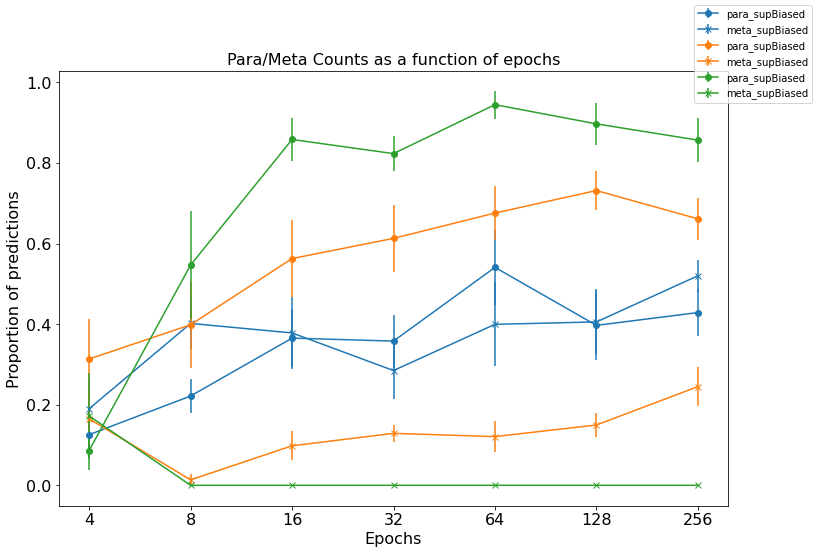

In [52]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
epochs = np.logspace(2,8,7, base=2)
fig, axs = plt.subplots()

for k in range(3):
    x = np.mean(para_counts[k], axis=1)
    xerr = np.std(para_counts[k], axis=1)/np.sqrt(len(xerr))
    y = np.mean(meta_counts[k], axis=1)
    yerr = np.std(meta_counts[k], axis=1)/np.sqrt(len(xerr))
    print('para/meta ratio for {} model: {:.1f}'.format(name, x[-1]/y[-1]))
    
    axs.errorbar(epochs, x, yerr=xerr, label='para_'+name, marker='o', color=colors[k])
    axs.errorbar(epochs, y, yerr=yerr, label='meta_'+name, marker='x', color=colors[k])

fig.legend()
axs.set_xscale('log', basex=2)
axs.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
axs.set_ylabel('Proportion of predictions', fontsize=16)
axs.set_xlabel('Epochs', fontsize=16)
axs.set_title('Para/Meta Counts as a function of epochs', fontsize=16)
axs.tick_params(axis='both', which='major', labelsize=16)